### Fetch data

#### Load dependencies

In [1]:
import sys
sys.path.insert(0, '/Users/shashankgupta/Documents/code/git_project/lending-rs2/code')

# core libraries
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

# load modules
from preprocess import Convert,MissingValues,Outlier,FeatureSelection
from feature_transformation import Scaler,Transform,Selection
from model_building import split_test_train, feature_encoding, classification_models
from model_evaluations import model_metrics, feature_importance, probability_bins, cross_validation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer

# object initiation 
# sc = Scaler()
tf = Transform()
sel = Selection()
ft = FeatureSelection()
cv = Convert()
mv = MissingValues()
ot = Outlier()

# set seed
seed = 40

In [2]:
corr_arr = 0.5
vif_arr = 5
features_arr = 15

### Fetching Data

In [3]:
# read from local
file = 'response_dataset.csv'
path = '/Users/shashankgupta/Documents/code/git_project/lending-model-pipeline/data/'
df_raw = pd.read_csv(path+file)
df_raw.shape

(6261, 452)

#### Exclude features based on business limitation

In [4]:
# exc = ['stddev_amount_insurance_credit_3m', 'stddev_amount_insurance_credit_1m', 'distinct_insurance_credit_txns_1m', 'ratio_tax_credit_total_credit_6m']

In [5]:
exclusion_list = ['BUSINESS_ID','BUSINESS_ID.1','BUSINESS_ID.2','Final_email','Product','Product.1','Segment','Segment.1','CREDIT_LIMIT','Interest_rate','CONTEXT_TRAITS_EMAIL','EMAIL_SENT_AT','BIZ_ID',\
                    'SIGNED_ON_X','SIGNED_ON_Y','BUSINESS_ID_X','PRODUCT_TYPE','FIRST_PAYMENT_DATE','SECOND_PAYMENT_DATE','THIRD_PAYMENT_DATE','PAST_1_MONTH',\
                    'PAST_2_MONTH','PAST_3_MONTH','BUSINESS_ID_Y','PRODUCT_ID','RUNNING_BALANCE','NUM_DAYS_SQUARE_OFF','FIRST_PAYMENT_FLAG','FPD','EXT_BUSINESS_ID',\
                    'EXTERNAL_ACC_LIST','PLAID_BUSINESS_ID','EXT_ACC_FLAG','PLAID_DATA_FLAG','FPD_PLUS_3','FPD_PLUS_2','FPD_PLUS_1','FPD_PLUS_4','DATE_OF_REFRESH',\
                    'ACCOUNT_CREATE_DATE','RATING','BUSINESS_PITCH','PURPOSE_OF_ACCOUNT','DATE_OF_ESTABLISHMENT','ESTIMATED_MONTHLY_REVENUE','INCOMING_ACH_PAYMENTS',\
                    'CHECK_DEPOSIT_AMOUNT','INCOMING_WIRE_TRANSFER','OUTGOING_ACH_AND_CHECKS','OUTGOING_WIRE_TRANSFERS','EMAIL_SENT_DATE','LOAN_TAKEN_DATE','EMAIL_SENT_WEEKDAY',\
                    'EMAIL_SENT_HOUR','RESPONSE_TARGET.2','RESPONSE_TARGET.1','EMAIL_SENT_AT.1','LOAN_TAKEN_DATE.1','FIRST_PAYMENT_DATE.1','RUNNING_BALANCE.1','FPD.1','FPD_PLUS_3.1',\
                    'DATE_OF_REFRESH.1','DAYS_ON_BOOK.1','APPLICATION_CHANNEL','EMAIL_DOMAIN','BUSINESS_TYPE','INDUSTRY_CATEGORY_NAME']

exclusion_list = exclusion_list 

In [6]:
df_raw = df_raw.drop(columns=exclusion_list, axis=1)
df_raw.shape

(6261, 384)

#### Data Preprocessing

In [7]:
# train test split
x_train, y_train, x_test, y_test = split_test_train(df_raw, target_column='RESPONSE_TARGET', test_size=0.3, random_state=seed)
print(f'{x_train.shape = }', '|' ,f'{y_train.shape = }', '|' ,f'{x_test.shape = }', '|' ,f'{y_test.shape = }')


# copy to df
df = x_train.copy()

x_train.shape = (4382, 383) | y_train.shape = (4382,) | x_test.shape = (1879, 383) | y_test.shape = (1879,)


In [8]:
df.reset_index(drop=True,inplace=True)
x_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [9]:
# get datatypes frequency
def get_datatypes_freq(dft):
    type_dct = {str(k): list(v) for k, v in dft.groupby(dft.dtypes, axis=1)}
    type_dct_info = {k: len(v) for k, v in type_dct.items()}
    return type_dct, type_dct_info

type_dct, type_dct_info = get_datatypes_freq(df)
type_dct_info

{'int64': 36, 'float64': 347}

#### Remove constant features

In [10]:
# get constant features
def get_const_features(dft):
    const_list = []
    for col in dft.columns: 
        if (len(dft[col].unique())==1):
            const_list.append(col)
    return(const_list)

# remove constant features
const_list = get_const_features(df)
df = df.drop(columns=const_list)
df.shape

(4382, 383)

#### Remove quasi-constant features

In [11]:
# get quasi-constant features
def get_quasi_const_features(dft, threshold=0.01):
    qconst_list = []
    for col in dft.columns: 
        if (dft[col].var() <= threshold):
            qconst_list.append(col)
    return(qconst_list)

# remove constant features
qconst_list = get_quasi_const_features(df, threshold=0.01)
df = df.drop(columns=qconst_list)
df.shape

(4382, 360)

#### Treat missing values

In [12]:
# view missing values
def missing_value(dft):
    percent_missing = dft.isnull().sum() * 100 / len(dft)
    missing_val_df = pd.DataFrame({'percent_missing': percent_missing})
    missing_val_df.sort_values(by='percent_missing', ascending=False, inplace=True)
    return missing_val_df

missing_value(df)

,percent_missing
RATIO_PD_AMT_TOTAL_CREDIT_1M,12.870835
RATIO_MRDC_AMT_TOTAL_CREDIT_1M,12.870835
RATIO_PD_FREQ_TOTAL_CREDIT_1M,12.848015
RATIO_CARD_AMT_TOTAL_DEBIT_1M,5.613875
RATIO_PD_AMT_TOTAL_CREDIT_3M,2.738476
...,...
STDDEV_AMOUNT_ACH_C_3M,0.000000
MEDIAN_AMOUNT_ACH_C_3M,0.000000
AVG_AMOUNT_ACH_C_3M,0.000000
AMOUNT_ACH_C_3M,0.000000


In [13]:
# fill missing values with median
for i in df.columns[df.isnull().any(axis=0)]:
    df[i].fillna(df[i].median(),inplace=True)

#### Get boolean columns

In [14]:
# # get boolean columns
# def findbool(df):
#     bool_arr = []
#     for col in df.columns: 
#         if (len(df[col].unique())<=2):
#             bool_arr.append(col)
#     return(bool_arr)

# bool_col_list = findbool(df)
# len(bool_col_list)

#### Cols except Bools

In [15]:
# type_dct, type_dct_info = get_datatypes_freq(df)
# col_list = (type_dct['int64'] + type_dct['float64'])
# col_list_excpt_bool = [column for column in col_list if column not in bool_col_list]

In [16]:
# for col in col_list_excpt_bool:
#     percentiles = df[col].quantile([0.01, 0.99]).values
#     df[col][df[col] <= percentiles[0]] = percentiles[0]
#     df[col][df[col] >= percentiles[1]] = percentiles[1]

In [17]:
col_list_excpt_bool = df.columns

#### Min-Max Capping

In [18]:
t1,t2 = tf.get_min_max_capping(df,col_list_excpt_bool,3)
df = df.drop(col_list_excpt_bool,axis=1)
t1.columns = col_list_excpt_bool
df = pd.concat([df, t1],axis=1)
df.shape

(4382, 360)

#### Standardisation

In [19]:
# reset index
# df.reset_index(drop=True, inplace=True)

# scaling
transformer = StandardScaler().fit(df[col_list_excpt_bool])
df[col_list_excpt_bool] = pd.DataFrame(transformer.transform(df[col_list_excpt_bool]), columns=col_list_excpt_bool)
df.shape

(4382, 360)

#### IV & WOE

In [20]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        
        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % of non-events and % of events
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

# remove features on basis of IV
y_train.reset_index(drop=True, inplace=True)
df['RESPONSE_TARGET'] = y_train
temp = df.copy()
t1, t2 = iv_woe(temp[np.append(col_list_excpt_bool,['RESPONSE_TARGET'])], 'RESPONSE_TARGET', bins=5, show_woe=False)
feature_list = list(t1[ (t1['IV']<0.5) & (t1['IV']>0.02) ]['Variable'].values)

Information value of EIN_IS_SSN is 0.005747
Information value of USER_COUNT is 0.016757
Information value of VIRTUAL_CARD_COUNT is 0.312452
Information value of IS_SLEEPER is 0.03512
Information value of NUMBER_OF_EMPLOYEES is 0.119819
Information value of COUNT_IOS_LOGINS is 0.009503
Information value of COUNT_ANDROID_LOGINS is 0.000556
Information value of COUNT_WEB_LOGINS is 0.008771
Information value of ROLLING_30_ALL_CREDITS_ACTIVE is 0.091133
Information value of ROLLING_60_ALL_CREDITS_ACTIVE is 0.039579
Information value of ROLLING_90_ALL_CREDITS_ACTIVE is 0.016095
Information value of ROLLING_30_ALL_DEBITS_ACTIVE is 0.03324
Information value of ROLLING_60_ALL_DEBITS_ACTIVE is 0.021722
Information value of BUSINESS_AGE_MONTHS is 0.028019
Information value of DAYS_ON_BOOK is 0.028821
Information value of MONTHS_ON_BOOK is 0.041068
Information value of QUARTERS_ON_BOOK is 0.060871
Information value of YEARS_ON_BOOK is 0.019423
Information value of COUNT_ALL_LOGINS is 0.005869
Info

#### Correlation and VIF

In [21]:
# view correlation
corr_df, subset_df = sel.get_correlated_features(df, feature_list, thresh=corr_arr)
corr_df

,feature_1,feature_2,corr
0,ROLLING_30_ALL_CREDITS_ACTIVE,ROLLING_60_ALL_CREDITS_ACTIVE,0.616682
1,ROLLING_60_ALL_CREDITS_ACTIVE,ROLLING_30_ALL_CREDITS_ACTIVE,0.616682
2,ROLLING_30_ALL_DEBITS_ACTIVE,ROLLING_60_ALL_DEBITS_ACTIVE,0.584287
3,ROLLING_60_ALL_DEBITS_ACTIVE,ROLLING_30_ALL_DEBITS_ACTIVE,0.584287
4,DAYS_ON_BOOK,MONTHS_ON_BOOK,0.998295
...,...,...,...
1689,DISTINCT_TAX_DEBIT_TXNS_3M,AMOUNT_TAX_DEBIT_6M,0.593074
1690,DISTINCT_TAX_DEBIT_TXNS_3M,DISTINCT_TAX_DEBIT_TXNS_6M,0.943390
1691,DISTINCT_TAX_DEBIT_TXNS_3M,DISTINCT_TAX_DEBIT_TXNS_1M,0.889359
1692,DISTINCT_TAX_DEBIT_TXNS_1M,DISTINCT_TAX_DEBIT_TXNS_6M,0.829352


In [22]:
# remove correlated features
feature_list = sel.corr_iter(df, np.array(feature_list), thresh=corr_arr)
feature_list = list(feature_list)
len(feature_list)

46

In [23]:
# get feature list after iterative VIF elimination
def vif_iter(dft, iv, threshold=10):
    vif_data = pd.DataFrame()
    vif_data["feature"] = iv
    vif_data["VIF"] = [variance_inflation_factor(dft[iv].values, i) for i in range(len(iv))]
    if len(vif_data[vif_data['VIF'] == np.inf]) > 0:
        feature = vif_data[vif_data['VIF'] == np.inf]['feature'].iloc[0]
        iv.remove(feature)
        vif_iter(dft, iv, threshold)
    elif len(vif_data[vif_data['VIF'] >= threshold]) > 0:
        feature = vif_data.sort_values(by='VIF', ascending=False)['feature'].iloc[0]
        iv.remove(feature)
        vif_iter(dft, iv, threshold)
    vif_data = pd.DataFrame()
    vif_data["feature"] = iv
    vif_data["VIF"] = [variance_inflation_factor(dft[iv].values, i) for i in range(len(iv))]
    return iv, vif_data

feature_list, vif_df = vif_iter(df, feature_list, threshold=vif_arr)
len(feature_list)

38

#### Backward Feature Selection

In [24]:
# final feature list
iv = feature_list
len(iv)

38

### Backward feature elimination

In [25]:
feat_list = ft.backward_feature_selection(df[iv], y_train, num_features=features_arr)
len(feat_list)

15

#### Fit Model

In [26]:
df.shape

(4382, 361)

In [27]:
# hyperparameters
params_log_reg = {'penalty': 'l1',
                  'random_state': seed,
                  'solver': 'liblinear',
                  'class_weight': {0:0.2, 1:0.8}}

# model fit
logreg_model = classification_models(df[feat_list], y_train, params_log_reg, models=['log_reg'])

Accuracy Score: 0.82 

Confusion Matrix:
        pred:0  pred:1
true:0    3334     504
true:1     286     258 

False Positive Rate: 0.13
True Positive Rate: 0.47
AUC: 0.67 

Sensitivity: 0.47
Specificity: 0.87 

F1 Score: 0.4 

KS Score:
KstestResult(statistic=0.04974897307165678, pvalue=3.886688058842487e-05) 

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      3838
           1       0.34      0.47      0.40       544

    accuracy                           0.82      4382
   macro avg       0.63      0.67      0.64      4382
weighted avg       0.85      0.82      0.83      4382

Gain Chart


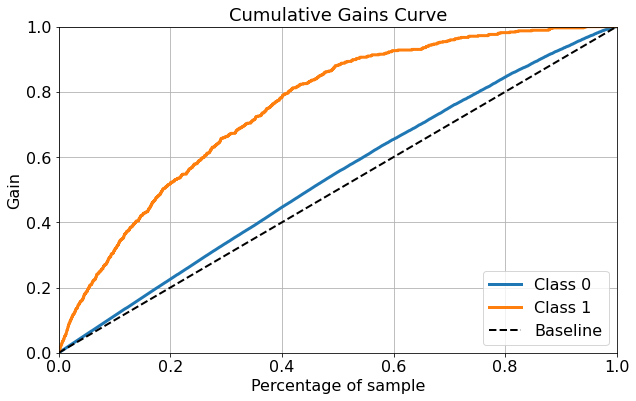

Lift Chart


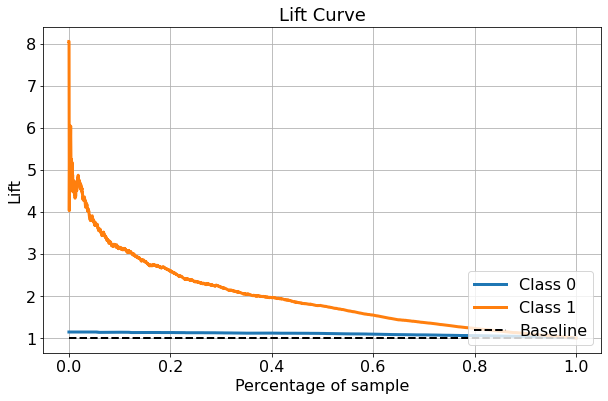

In [28]:
# train score
model_metrics(logreg_model.predict(df[feat_list]), np.array(y_train), logreg_model.predict_proba(df[feat_list]))

In [29]:
feat_imp = feature_importance(logreg_model, df[feat_list], show_plot=True)

In [30]:
feat_imp.sort_values(by='importance', ascending=False)

,importance
VIRTUAL_CARD_COUNT,0.342701
NUMBER_OF_EMPLOYEES,0.237196
DISTINCT_LOAN_DEBIT_TXNS_1M,0.226162
RATIO_CARD_WITHDRAWAL_AMT_90_180,0.199273
DISTINCT_ACH_D_TXNS_100_6M,0.187972
BUSINESS_AGE_MONTHS,0.185770
DISTINCT_CARD_TXNS_1000_6M,0.183522
DISTINCT_INSURANCE_DEBIT_TXNS_1M,0.181230
OD_COUNT_1M,0.168255
IS_ACH_CREDIT,0.150732


In [31]:
feats = list(feat_imp.index)

Accuracy Score: 0.84 

Confusion Matrix:
        pred:0  pred:1
true:0    1460     186
true:1     114     119 

False Positive Rate: 0.11
True Positive Rate: 0.51
AUC: 0.7 

Sensitivity: 0.51
Specificity: 0.89 

F1 Score: 0.44 

KS Score:
KstestResult(statistic=0.03831825439063331, pvalue=0.1266965388323586) 

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1646
           1       0.39      0.51      0.44       233

    accuracy                           0.84      1879
   macro avg       0.66      0.70      0.67      1879
weighted avg       0.86      0.84      0.85      1879

Gain Chart


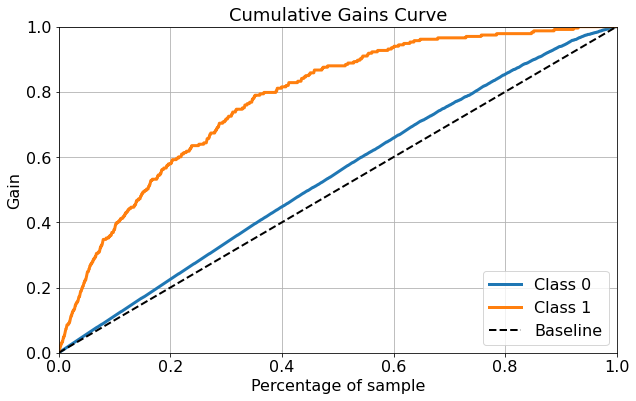

Lift Chart


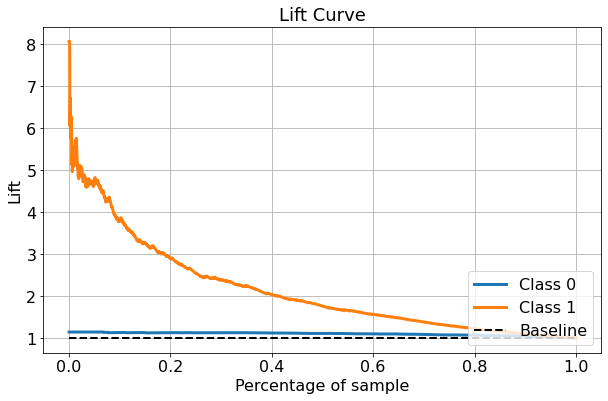

In [32]:
# reset index
x_test.reset_index(drop=True, inplace=True)

# treat missing values
for i in x_test.columns[x_test.isnull().any(axis=0)]:
    x_test[i].fillna(x_test[i].median(),inplace=True)

# min-max capping
t1,t2 = tf.get_min_max_capping(x_test,col_list_excpt_bool,3)
x_test = x_test.drop(col_list_excpt_bool,axis=1)
t1.columns = col_list_excpt_bool
x_test = pd.concat([x_test, t1],axis=1)
# transformer = StandardScaler().fit(x_test[col_list_excpt_bool])

x_test[col_list_excpt_bool] = pd.DataFrame(transformer.transform(x_test[col_list_excpt_bool]), columns=col_list_excpt_bool)
x_test.shape

# test score
model_metrics(logreg_model.predict(x_test[feat_list]), np.array(y_test), logreg_model.predict_proba(x_test[feat_list]))

#### Probability Bins

In [33]:
# reset index
df_raw.reset_index(drop=True, inplace=True)

# treat missing values
for i in df_raw.columns[df_raw.isnull().any(axis=0)]:
    df_raw[i].fillna(df_raw[i].median(),inplace=True)

#min-max capping
t1,t2 = tf.get_min_max_capping(df_raw,col_list_excpt_bool,3)
df_raw = df_raw.drop(col_list_excpt_bool,axis=1)
t1.columns = col_list_excpt_bool
df_raw = pd.concat([df_raw, t1],axis=1)

# scaling
df_raw[col_list_excpt_bool] = pd.DataFrame(transformer.transform(df_raw[col_list_excpt_bool]), columns=col_list_excpt_bool)
df_raw.shape

predicted_probas = logreg_model.predict_proba(df_raw[feat_list])
df_raw['proba'] = predicted_probas[:,1:].flatten()
px.histogram(df_raw['proba'], nbins=100)

In [34]:
df_test = x_test.copy()
df_test = pd.concat([df_test,y_test],axis=1)

In [35]:
df_raw['proba'] = np.round(df_raw['proba'], 3)
df_raw['DecileRank']= pd.qcut(df_raw['proba'], q = 5)
df_stats = pd.DataFrame(df_raw.groupby(by='DecileRank')['RESPONSE_TARGET'].mean())
df_stats['volume'] = df_raw.groupby(by='DecileRank')['RESPONSE_TARGET'].size()
df_stats

,RESPONSE_TARGET,volume
DecileRank,,
"(-0.001, 0.115]",0.011924,1258
"(0.115, 0.234]",0.031847,1256
"(0.234, 0.348]",0.085072,1246
"(0.348, 0.471]",0.159073,1251
"(0.471, 0.986]",0.333600,1250


In [36]:
# df_test['proba'] = np.round(df_test['proba'], 3)
# df_test['DecileRank']= pd.qcut(df_test['proba'], q = 5)
# df_test = pd.DataFrame(df_test.groupby(by='DecileRank')['fpd_plus_3'].mean())
# df_stats['volume'] = df_test.groupby(by='DecileRank')['fpd_plus_3'].count()
# df_stats

#### Cross Validation

In [37]:
cv_scores = cross_validation(logreg_model, df_raw[feat_list], df_raw['RESPONSE_TARGET'], scoring='roc_auc', folds=5, seed=seed)
print('CV Scores -',np.round(cv_scores, 2))
print('Mean of CV Scores -',np.round(np.mean(cv_scores),2))

CV Scores - [0.79 0.8  0.8  0.79 0.79]
Mean of CV Scores - 0.8


#### p-value

In [38]:
# X2 = sm.add_constant(df[feat_list])
# est = sm.Logit(list(y_train), X2)
# est_fit = est.fit()
# print(est_fit.summary())

In [39]:
# df_pval = pd.DataFrame(est_fit.pvalues, columns=['p-value'])
# df_pval.sort_values(by='p-value', ascending=False)

In [40]:
feat_imp

,importance
VIRTUAL_CARD_COUNT,0.342701
IS_SLEEPER,-0.337883
NUMBER_OF_EMPLOYEES,0.237196
BUSINESS_AGE_MONTHS,0.185770
QUARTERS_ON_BOOK,-0.127273
IS_ACH_CREDIT,0.150732
RATIO_CARD_WITHDRAWAL_AMT_90_180,0.199273
DEBIT_SIZE_6M,-1.462265
DISTINCT_ACH_D_TXNS_100_6M,0.187972
DISTINCT_CARD_TXNS_1000_6M,0.183522


In [41]:
feats

['VIRTUAL_CARD_COUNT',
 'IS_SLEEPER',
 'NUMBER_OF_EMPLOYEES',
 'BUSINESS_AGE_MONTHS',
 'QUARTERS_ON_BOOK',
 'IS_ACH_CREDIT',
 'RATIO_CARD_WITHDRAWAL_AMT_90_180',
 'DEBIT_SIZE_6M',
 'DISTINCT_ACH_D_TXNS_100_6M',
 'DISTINCT_CARD_TXNS_1000_6M',
 'CREDIT_UTILISATION_6M',
 'OD_COUNT_1M',
 'DISTINCT_LOAN_DEBIT_TXNS_1M',
 'DISTINCT_INSURANCE_DEBIT_TXNS_1M',
 'DISTINCT_TAX_DEBIT_TXNS_3M']

In [43]:
minus_feat = ['DEBIT_SIZE_6M','CREDIT_UTILISATION_6M']


In [44]:
def trim_features(feat_list,minus_feat):
    for feat in minus_feat:
        feat_list.remove(feat)
    return feat_list

feat_list = trim_features(feats,minus_feat)
len(feat_list)

13

In [45]:
# hyperparameters
params_log_reg = {'penalty': 'l1',
                  'random_state': seed,
                  'solver': 'liblinear',
                  'class_weight': {0:0.2, 1:0.8}}

# model fit
logreg_model = classification_models(df[feat_list], y_train, params_log_reg, models=['log_reg'])

Accuracy Score: 0.82 

Confusion Matrix:
        pred:0  pred:1
true:0    3349     489
true:1     320     224 

False Positive Rate: 0.13
True Positive Rate: 0.41
AUC: 0.64 

Sensitivity: 0.41
Specificity: 0.87 

F1 Score: 0.36 

KS Score:
KstestResult(statistic=0.0385668644454587, pvalue=0.0029512530284835177) 

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3838
           1       0.31      0.41      0.36       544

    accuracy                           0.82      4382
   macro avg       0.61      0.64      0.62      4382
weighted avg       0.84      0.82      0.83      4382

Gain Chart


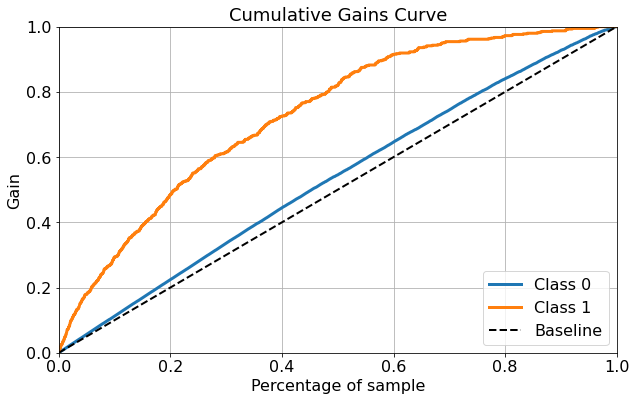

Lift Chart


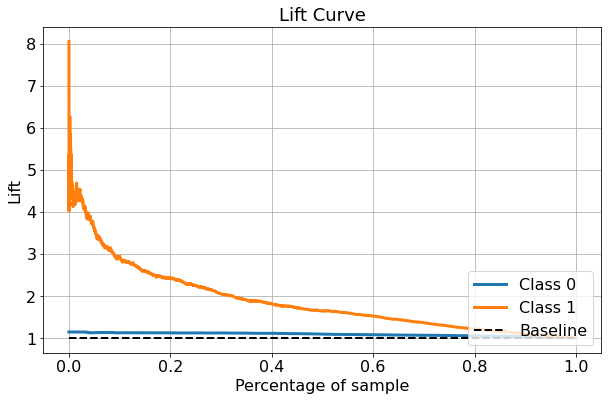

In [46]:
# train score
model_metrics(logreg_model.predict(df[feat_list]), np.array(y_train), logreg_model.predict_proba(df[feat_list]))

Accuracy Score: 0.83 

Confusion Matrix:
        pred:0  pred:1
true:0    1455     191
true:1     130     103 

False Positive Rate: 0.12
True Positive Rate: 0.44
AUC: 0.66 

Sensitivity: 0.44
Specificity: 0.88 

F1 Score: 0.39 

KS Score:
KstestResult(statistic=0.032464076636508785, pvalue=0.2753793471062597) 

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1646
           1       0.35      0.44      0.39       233

    accuracy                           0.83      1879
   macro avg       0.63      0.66      0.65      1879
weighted avg       0.85      0.83      0.84      1879

Gain Chart


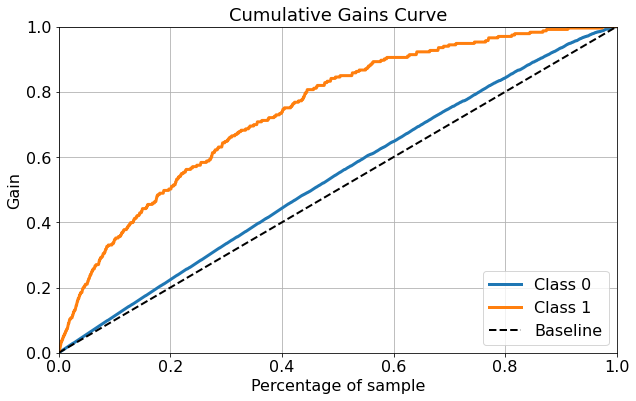

Lift Chart


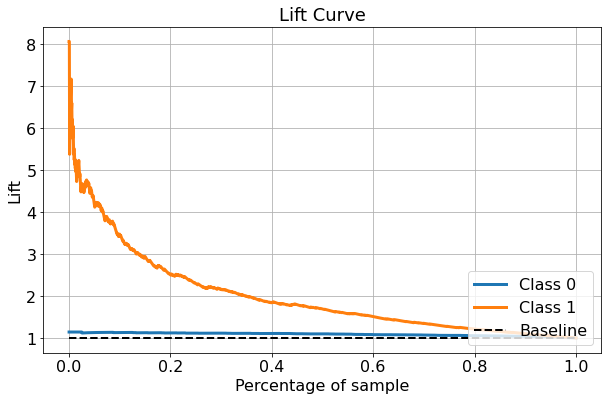

In [47]:
#Test score
model_metrics(logreg_model.predict(x_test[feat_list]), np.array(y_test), logreg_model.predict_proba(x_test[feat_list]))

In [48]:
feat_imp = feature_importance(logreg_model, df[feat_list], show_plot=True)

In [49]:
df_train = df.copy()
df_train['RESPONSE_TARGET'] = y_train

df_test = x_test.copy()
df_test['RESPONSE_TARGET'] = y_test

In [50]:
df_train['proba'] = logreg_model.predict_proba(df[feat_list])[:,1:].flatten()
df_test['proba'] = logreg_model.predict_proba(x_test[feat_list])[:,1:].flatten()

In [51]:
df_test['proba'] = np.round(df_test['proba'], 3)
df_test['DecileRank']= pd.qcut(df_test['proba'], q = 5)
df_stats = pd.DataFrame(df_test.groupby(by='DecileRank')['RESPONSE_TARGET'].mean())
df_stats['volume'] = df_test.groupby(by='DecileRank')['RESPONSE_TARGET'].size()
df_stats

,RESPONSE_TARGET,volume
DecileRank,,
"(0.0, 0.155]",0.018519,378
"(0.155, 0.24]",0.040107,374
"(0.24, 0.325]",0.105263,380
"(0.325, 0.452]",0.145161,372
"(0.452, 0.964]",0.312000,375


In [52]:
df_train['proba'] = np.round(df_train['proba'], 3)
df_train['DecileRank']= pd.qcut(df_train['proba'], q = 5)
df_stats = pd.DataFrame(df_train.groupby(by='DecileRank')['RESPONSE_TARGET'].mean())
df_stats['volume'] = df_train.groupby(by='DecileRank')['RESPONSE_TARGET'].size()
df_stats

,RESPONSE_TARGET,volume
DecileRank,,
"(0.001, 0.151]",0.018161,881
"(0.151, 0.234]",0.035469,874
"(0.234, 0.326]",0.117045,880
"(0.326, 0.46]",0.150575,870
"(0.46, 0.989]",0.299886,877


In [53]:
def model_bin(x):
    if x < 0.15:
        return 1
    if x < 0.25:
        return 2
    if x < 0.35:
        return 3
    if x < 0.45:
        return 4
    else:
        return 5

In [54]:
def pred(model, dft):
    dft['response_proba'] = model.predict_proba(dft)[:,1:].flatten()
    dft['response_score'] = 1000*(1-dft['response_proba'])
    dft['response_bin'] = dft['response_proba'].apply(lambda x: model_bin(x))
    return dft[['response_proba','response_score','response_bin']]

In [55]:
df_raw['proba'] = logreg_model.predict_proba(df_raw[feat_list])[:,1:].flatten()
pred_df = pred(logreg_model,df_raw[feat_list])

In [56]:
df_data = pd.read_csv(path+file)
df_data = df_data['BUSINESS_ID']

In [57]:
df_data = pd.concat([df_data,pred_df],axis=1)

In [58]:
df_data.head()

,BUSINESS_ID,response_proba,response_score,response_bin
0,6d42e506-678e-466b-9e3f-339690855898,0.331125,668.874531,3
1,fe80a1fd-ebb0-4ed3-b691-0578396cc757,0.613327,386.673434,5
2,58eef423-fb7b-4d17-a20d-dded2f9be440,0.524594,475.405799,5
3,6823f6da-af22-4d1a-b7b3-4038079d64b9,0.616061,383.939190,5
4,77125e69-1002-4234-b33f-33d2540b945c,0.383690,616.309659,4


In [59]:
df_data['response_bin'].value_counts().sort_index()

1    1218
2    1506
3    1313
4     915
5    1309
Name: response_bin, dtype: int64